# Вебинар 3. Коллаборативная фильтрация

Исчерпывающую информацию с теорией, кодом и примерами можно найти в [статье](https://www.ethanrosenthal.com/2016/10/19/implicit-mf-part-1/)

# 1. Матричная факторизация

### 1. Базовое применение

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

# # Функции из 1-ого вебинара
# import os, sys

# module_path = os.path.abspath(os.path.join(os.pardir))
# if module_path not in sys.path:
#     sys.path.append(module_path)
    
# from metrics import precision_at_k, recall_at_k

In [ ]:
# import module we'll need to import our custom module
from shutil import copyfile

# copy our file into the working directory (make sure it has .py suffix)
copyfile(src = "../input/implicit/metrics.py", dst = "../working/metrics.py")

# import all our functions
from metrics import precision_at_k, recall_at_k

In [ ]:
data = pd.read_csv('../input/implicit/retail_train.csv')

data.columns = [col.lower() for col in data.columns]
data.rename(columns={'household_key': 'user_id',
                    'product_id': 'item_id'},
           inplace=True)


test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.head(10)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0
5,2375,26984851516,1,826249,2,1.98,364,-0.60,1642,1,0.0,0.0
6,2375,26984851516,1,1043142,1,1.57,364,-0.68,1642,1,0.0,0.0
7,2375,26984851516,1,1085983,1,2.99,364,-0.40,1642,1,0.0,0.0
8,2375,26984851516,1,1102651,1,1.89,364,0.00,1642,1,0.0,0.0
9,2375,26984851516,1,6423775,1,2.00,364,-0.79,1642,1,0.0,0.0


In [ ]:
item_features = pd.read_csv('../input/implivit11/product.csv')
item_features.columns = [col.lower() for col in item_features.columns]
item_features.rename(columns={'product_id': 'item_id'}, inplace=True)

item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [ ]:
item_features.department.unique()

array(['GROCERY', 'MISC. TRANS.', 'PASTRY', 'DRUG GM', 'MEAT-PCKGD',
       'SEAFOOD-PCKGD', 'PRODUCE', 'NUTRITION', 'DELI', 'COSMETICS',
       'MEAT', 'FLORAL', 'TRAVEL & LEISUR', 'SEAFOOD', 'MISC SALES TRAN',
       'SALAD BAR', 'KIOSK-GAS', 'ELECT &PLUMBING', 'GRO BAKERY',
       'GM MERCH EXP', 'FROZEN GROCERY', 'COUP/STR & MFG', 'SPIRITS',
       'GARDEN CENTER', 'TOYS', 'CHARITABLE CONT', 'RESTAURANT', 'RX',
       'PROD-WHS SALES', 'MEAT-WHSE', 'DAIRY DELI', 'CHEF SHOPPE', 'HBC',
       'DELI/SNACK BAR', 'PORK', 'AUTOMOTIVE', 'VIDEO RENTAL', ' ',
       'CNTRL/STORE SUP', 'HOUSEWARES', 'POSTAL CENTER', 'PHOTO', 'VIDEO',
       'PHARMACY SUPPLY'], dtype=object)

In [ ]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [ ]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

In [ ]:
data_train.head(5)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


In [ ]:
# Заведем фиктивный item_id

data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999_999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробоват ьдругие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix)

user_item_matrix.head(3)

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

# ALS

In [ ]:
%%time

model = AlternatingLeastSquares(factors=64, 
                                regularization=0.05,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=10,
                                use_gpu=False)

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)


  0%|          | 0/15 [00:00<?, ?it/s]

CPU times: user 21.9 s, sys: 10.6 s, total: 32.5 s
Wall time: 8.51 s


In [ ]:
recs = model.recommend(userid=userid_to_id[2],  # userid - id от 0 до N
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, # кол-во рекомендаций 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=True)

In [ ]:
[id_to_itemid[rec[0]] for rec in recs]

[999999, 1133018, 5569230, 1106523, 1082185]

In [ ]:
def get_recommendations(user, model, N=5):
    res = [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[user], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items=None, 
                                    recalculate_user=True)]
    return res

In [ ]:
%%time
    
result['als'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))

result.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean()

CPU times: user 1min 14s, sys: 1min 6s, total: 2min 21s
Wall time: 36.1 s


0.16611165523996085

In [ ]:
result.head(2)

,user_id,actual,als
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[1051211, 1033142, 1100972, 832678, 999999]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[5568378, 1106523, 951590, 910032, 1092026]"


### Embeddings

In [ ]:
model.item_factors.shape

(5001, 64)

In [ ]:
model.user_factors.shape

(2499, 64)

In [ ]:
# model.rank_items()

Можно очень быстро посчитать предсказания, перемножив эти 2 матрицы

In [ ]:
fast_recs = model.user_factors @ model.item_factors.T 
fast_recs.shape

(2499, 5001)

In [ ]:
fast_recs[0,:]

array([ 0.01294248,  0.05338495,  0.01419892, ...,  0.01261283,
        0.04509171, -0.05389111], dtype=float32)

In [ ]:
%%time
recommendations = model.recommend_all(N=5, 
                                      user_items=csr_matrix(user_item_matrix).tocsr(),
                                      filter_already_liked_items=True, 
                                      filter_items=None, 
                                      recalculate_user=True,
                                      show_progress=True,
                                      batch_size=500)
recommendations

  0%|          | 0/2499 [00:00<?, ?it/s]

CPU times: user 1min 17s, sys: 1min 6s, total: 2min 24s
Wall time: 37.3 s


array([[3031, 3616,  192,  832,  661],
       [2757, 2307, 4346, 2148, 1178],
       [2757, 3388,  558, 2307, 1516],
       ...,
       [2307, 4346, 3587, 2148,  558],
       [2757,  300,  657, 2307, 2847],
       [ 558, 4060, 3688, 2216, 2454]], dtype=int32)

In [ ]:
recommendations.shape

(2499, 5)

# Попробуем визуализировать для оценки

In [ ]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import cm
import pickle

from scipy.spatial.distance import cdist

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import seaborn as sns


def reduce_dims(df, dims=2, method='pca'):
    
    assert method in ['pca', 'tsne'], 'Неверно указан метод'
    
    if method=='pca':
        pca = PCA(n_components=dims)
        components = pca.fit_transform(df)
    elif method == 'tsne':
        tsne = TSNE(n_components=dims, learning_rate=250, random_state=42)
        components = tsne.fit_transform(df)
    else:
        print('Error')
        
    colnames = ['component_' + str(i) for i in range(1, dims+1)]
    return pd.DataFrame(data = components, columns = colnames) 


def display_components_in_2D_space(components_df, labels='category', marker='D'):
    
    groups = components_df.groupby(labels)

    # Plot
    fig, ax = plt.subplots(figsize=(12,8))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
    for name, group in groups:
        ax.plot(group.component_1, group.component_2, 
                marker='o', ms=6,
                linestyle='',
                alpha=0.7,
                label=name)
    ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5))

    plt.xlabel('component_1')
    plt.ylabel('component_2') 
    plt.show()

In [ ]:
model.item_factors.shape

(5001, 64)

In [ ]:
category = []

for idx in range(model.item_factors.shape[0]):

    try:
        cat = item_features.loc[item_features['item_id'] == id_to_itemid[idx], 'department'].values[0]
        category.append(cat)
    except:
        category.append('UNKNOWN')

In [ ]:
print(category[:10])

['MISC SALES TRAN', 'KIOSK-GAS', 'MISC SALES TRAN', 'KIOSK-GAS', 'MISC SALES TRAN', 'MISC SALES TRAN', 'KIOSK-GAS', 'GROCERY', 'GROCERY', 'GROCERY']


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


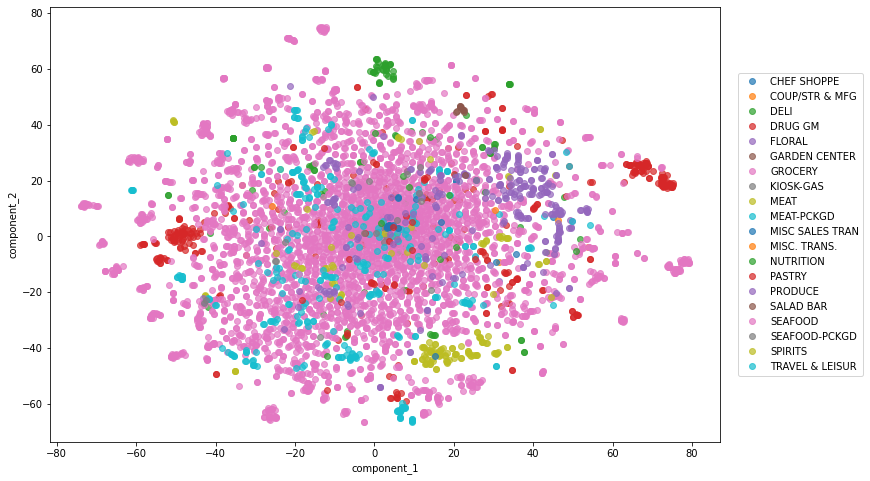

CPU times: user 2min 14s, sys: 848 ms, total: 2min 15s
Wall time: 35 s


In [ ]:
%%time
item_emb_tsne = reduce_dims(model.item_factors, dims=2, method='tsne') # 5001 х 100  ---> 5001 x 2
item_emb_tsne['category'] = category  # Добавляем категорию
item_emb_tsne = item_emb_tsne[item_emb_tsne['category'] != 'UNKNOWN']

display_components_in_2D_space(item_emb_tsne, labels='category')

Нарисуем все, кроме GROCERY

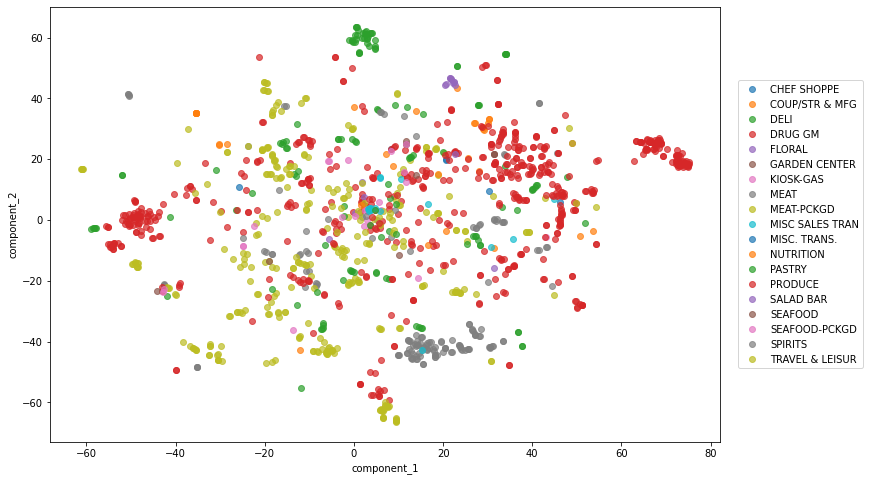

In [ ]:
display_components_in_2D_space(item_emb_tsne[item_emb_tsne['category'] != 'GROCERY'], labels='category')

Нарисуем несколько конкретных категорий

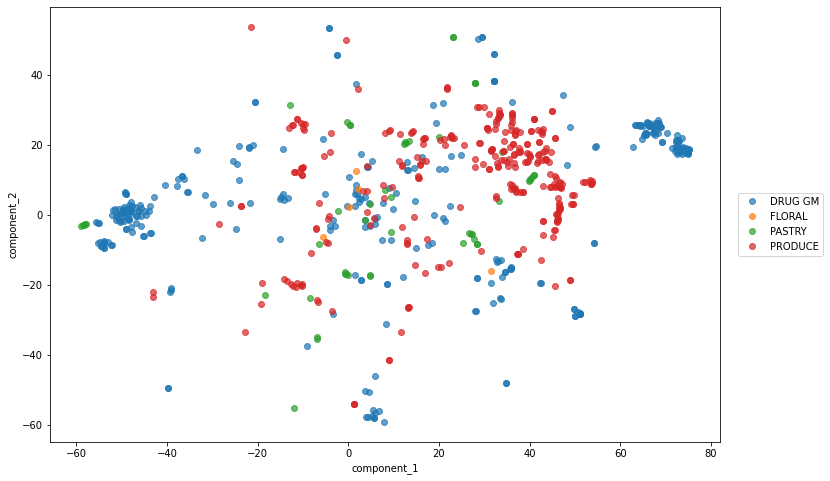

In [ ]:
interesting_cats = ['PASTRY', 'PRODUCE', 'DRUG GM', 'FLORAL']

display_components_in_2D_space(item_emb_tsne[item_emb_tsne['category'].isin(interesting_cats)], 
                                             labels='category')

На самом деле, я бы сказал, что **результат средний**:
- Модель выучила похожесть только небольшой части товаров

In [ ]:
item_emb_tsne.head(2)

,component_1,component_2,category
0,3.610965,4.017197,MISC SALES TRAN
1,6.048657,3.123366,KIOSK-GAS


recommend_all делает перемножение, но еще и сортирует и выбирает топ-N

In [ ]:
item_1 = model.item_factors[1]
item_2 = model.item_factors[2]

In [ ]:
item_1.shape

(64,)

*Посмотрите также / Похожие товары*

In [ ]:
example_item_row_id = 3606

In [ ]:
id_to_itemid[example_item_row_id]

1100265

In [ ]:
closest_items = [ id_to_itemid[row_id] for row_id, score in model.similar_items(example_item_row_id, N=5)]

In [ ]:
closest_items

[1100265, 1101174, 1051626, 899459, 5995483]

In [ ]:
item_features[item_features.item_id.isin(closest_items)]

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
14959,899459,69,GROCERY,Private,CHEESE,NATURAL CHEESE EXACT WT CHUNKS,1 LB
32127,1051626,69,GROCERY,Private,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12 OZ
37579,1100265,69,GROCERY,Private,CHEESE,NATURAL CHEESE EXACT WT SLICES,10 OZ
37680,1101174,1251,GROCERY,National,SOUP,CONDENSED SOUP,10.75OZ
55409,5995483,1329,GROCERY,National,DRY BN/VEG/POTATO/RICE,RICE - INSTANT & MICROWAVE,8.8 OZ


*Вашим друзьям нравится / Похожим пользователям нравится / ...*

Пользователь --> похожих пользовтелей --> рекомендовать те товары, которые купили похожие юзеры

In [ ]:
model.similar_users(userid_to_id[10], N=5)

[(9, 1.0000001),
 (790, 0.98305863),
 (354, 0.9802671),
 (239, 0.9773074),
 (1380, 0.97651887)]

### 2. TF-IDF взвешивание

In [ ]:
user_item_matrix = tfidf_weight(user_item_matrix.T).T  # Применяется к item-user матрице ! 

In [ ]:
%%time

model = AlternatingLeastSquares(factors=64, 
                                regularization=0.05,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=10)

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)


  0%|          | 0/15 [00:00<?, ?it/s]

CPU times: user 20.6 s, sys: 10 s, total: 30.6 s
Wall time: 7.76 s


In [ ]:
result['als_tfidf'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))

result.apply(lambda row: precision_at_k(row['als_tfidf'], row['actual']), axis=1).mean()

0.17296767874632715

In [ ]:
(1 - 0.15/0.16) * 100

6.25

### 3. BM25 взвешивание

In [ ]:
# Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробоват ьдругие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
user_item_matrix = bm25_weight(user_item_matrix.T).T  # Применяется к item-user матрице ! 

In [ ]:
%%time

# model = AlternatingLeastSquares(factors=128, 
#                                 regularization=0.05,
#                                 iterations=15, 
#                                 calculate_training_loss=True, 
#                                 num_threads=4) # K - кол-во билжайших соседей

model = AlternatingLeastSquares(factors=64, 
                                regularization=0.05,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=10)

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

result['als_bm25'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))

  0%|          | 0/15 [00:00<?, ?it/s]

CPU times: user 1min 36s, sys: 1min 15s, total: 2min 52s
Wall time: 44.3 s


In [ ]:
result.apply(lambda row: precision_at_k(row['als_bm25'], row['actual']), axis=1).mean()

0.18374142997061704

In [ ]:
result.to_csv('/predictions_mf.csv', index=False)  # mf - matrix factorization

## 4. Важно искать оптимальные параметры

- regularization, iterations(+-)
- factors
- Вес (элемент в матрице user-item)

# Production

Начиная с этого вебинара, мы будем строить *базовое решение* для системы рекомендаций топ-N товаров. В финальном проекте вам нужно будет его существенно улучшить.  
  
**Ситуация**: Вы работает data scientist в крупном продуктовом российском ритейлере. Ваш конкурент сделал рекомендательную систему, и его продажи выросли. Ваш менеджмент тоже хочет увеличить продажи   
**Задача со слов менеджера**: Сделайте рекомендательную систему топ-10 товаров для рассылки по e-mail

**Ожидание:**
- Отправляем e-mail с топ-10 товарами, отсортированными по вероятности

**Реальность:**
- Чего хочет менеджер от рекомендательной системы? (рост показателя X на Y% за Z недель)
- По-хорошему надо бы предварительно посчитать потенциальный эффект от рекоммендательной системы (Оценки эффектов у менеджера и у вас могут сильно не совпадать: как правило, вы знаете про данные больше)
- А у нас вообще есть e-mail-ы пользователей? Для скольки %? Не устарели ли они?
- Будем ли использовать СМС и push-уведомления в приложении? Может, будем печатать рекомендации на чеке после оплаты на кассе?
- Как будет выглядеть e-mail? (решаем задачу топ-10 рекомендаций или ранжирования? И топ-10 ли?)
- Какие товары должны быть в e-mail? Есть ли какие-то ограничения (только акции и т п)?
- Сколько денег мы готовы потратить на привлечение 1 юзера? CAC - Customer Aquisition Cost. Обычно CAC = расходы на коммуникацию + расходы на скидки
- Cколько мы хотим зарабатывать с одного привлеченного юзера?
---
- А точно нужно сортировать по вероятности?
- Какую метрику использовать?
- Сколько раз в неделю отпрпавляем рассылку?
- В какое время отправляем рассылку?
- Будем отправлять одному юзеру много раз наши рекоммендации. Как добиться того, чтобы они хоть немного отличались?
- Нужно ли, чтобы в одной рассылке были *разные* товары? Как определить, что товары *разные*? Как добиться того, чтобы они были разными?
- И многое другое:)

**В итоге договорились, что:**
- Хотим повысить выручку минимум на 6% за 4 месяца. Будем повышать за счет роста Retention минимум на  3% и среднего чека минимум на 3%
- Топ-5 товаров, а не топ-10 (В e-mail 10 выглядят не красиво, в push и на чек больше 5 не влезает)
- Рассылаем в e-mail (5% клиентов) и push-уведомлении (20% клиентов), печатаем на чеке (все оффлайн клиенты)
- **3 товара с акцией** (Как это учесть? А если на товар была акция 10%, а потом 50%, что будет стоять в user-item матрице?)
- **1 новый товар** (юзер никогда не покупал. Просто фильтруем аутпут ALS? А если у таких товаров очень маленькая вероятность покупки? Может, использовать другую логику/модель?) 
- **1 товар для роста среднего чека** (товары минимум дороже чем обычно покупает юзер. Как это измерить? На сколько дороже?)

Вопросов стало еще больше. Поэтому сначала делаем **MVP** (Minimum viable product) на e-mail. Показываем его менеджеру, измеряем метрики на юзерах. По фидбеку и метрикам делаем улучшения MVP и раскатываем его на push-уведомления и чеки

*Data Science проект* - итеративный процесс!

In [ ]:
data_train.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [ ]:
data_train['price'] = data_train['sales_value'] / (np.maximum(data_train['quantity'], 1))
data_train['price'].max()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


499.99

In [ ]:
# < 1$
data_train['price'].quantile(0.20)

0.99

In [ ]:
# > 100$
data_train['price'].quantile(0.99995)

82.01435450003483

In [ ]:
def prefilter_items(data):
    # Уберем самые популярные товары (их и так купят)
    popularity = data_train.groupby('item_id')['user_id'].nunique().reset_index() / data_train['user_id'].nunique()
    popularity.rename(columns={'user_id': 'share_unique_users'}, inplace=True)
    
    top_popular = popularity[popularity['share_unique_users'] > 0.5].item_id.tolist()
    data = data[~data['item_id'].isin(top_popular)]
    
    # Уберем самые НЕ популярные товары (их и так НЕ купят)
    top_notpopular = popularity[popularity['share_unique_users'] < 0.01].item_id.tolist()
    data = data[~data['item_id'].isin(top_notpopular)]
    
    # Уберем товары, которые не продавались за последние 12 месяцев
    
    # Уберем не интересные для рекоммендаций категории (department)
    
    # Уберем слишком дешевые товары (на них не заработаем). 1 покупка из рассылок стоит 60 руб. 
    
    # Уберем слишком дорогие товарыs
    
    # ...
    
def postfilter_items(user_id, recommednations):
    pass

Все эти функции отправим затем в *utils.py*

# ДЗ

1) Попытаться ответить на вопросы/выдвинуть гипотезы

2) Доделать прошлые домашния задания

3) Прочитать статьи BM25/MatrixFactorization

4) Поэкспериментировать с ALS (grid-search)

## Практика:

4) Поэкспериментировать с ALS (grid-search) ********
   * Подобрать лучшие параметры
   * Написать отчет об увиденном

### **Ответы-Рассуждения:**
- Необходимо проанализировать состояние e-mail данных. Если брать всех покупателей данного ритейла, то из них только часть имеет карточки лояльности или приложения на телефоне, к которым привязан e-mail. Необходимо выяснить, какой процент этих e-mail являются активными. Среди них взять группу пользователей, для которых будем делать рассылку.
- СМС использовать не будем, так как делаем рассылку в другие каналы связи. Лишний раз не раздражать покупателя. Телефон подходит больше для экстренной связи. (Из личного опыта взаимодействия с Озоном, в почту, приложение присылают одно и тоже, иногда по несколько раз на дню, за такое хочется просто поставить в бан этот сервис навсегда)
- Push-уведомления можем использовать.
- Печатать на чеке рекомендации не будем. (Опять же из личного опыта, на чеке слишком много информации, особенно когда большой список покупок, он и так длинный, еще впихивать рекомендации не слишком хорошая идея. К тому же чеки часто теряются, после выхода из магазина выкидываются, благо если покупатель будет сверять стоимость товара, иногда и это мимо него проходит, если не то пробили)
- В e-mail отправляем 5 товаров (при этом можно расположить 3 в верхнем ряду поменьше, 2 в нижнем ряду побольше размером), в push - 1 товар (больше не поместится).
- Стоимоть привлечения 1 юзера будет минимальная, так как мы не используем СМС-рассылку и не печатаем на чеках (меньший расход бумаги, чернил). Что касается расходов на скидки, то кажется, что в любом случае должна быть выгода (либо товара купят больше, например 2 молока вместо 1-го, либо его купят в принципе, хотя не планировали), исходя из той мысли, что скидки/акции делаются в большинстве случаев на товары, которые плохо продаются или выходит срок годности.
- Среди рекомендованных товаров предлагается выбрать 3 по акции (верхний ряд), 2 новых товара (нижний ряд).
- Рассылку по e-mail делать 1 раз в неделю утром (вероятность, что например, покупатель зайдет в почту с утра в метро, за завтраком, выше, чем в середине рабочего дня или вечером). Push-рассылку можно сделать 3 раза в неделю с уведомлением про сроки 1-го из акционных товаров. Чтобы напомнить.
- Для оценки результата будем использовать метрику money precision@5, так как она учитывает денежную составляющую в подсчете.

### **Подбор параметров:**

In [ ]:
param_grid = {'factors': [40, 64, 80],
              'regularization': [0.05, 0.1, 0.5],
              'iterations': [10, 15, 20]}

In [ ]:
%%time

# Возьмем модель с BM25 взвешиванием, и попытаемся найти наилучшие параметры для метода ALS

params = []
begin = 0
for fac in param_grid['factors']:
    for reg in param_grid['regularization']:
        for ite in param_grid['iterations']:
            model = AlternatingLeastSquares(factors=fac, 
                                    regularization=reg,
                                    iterations=ite, 
                                    calculate_training_loss=True, 
                                    num_threads=10,
                                    random_state=42)
            model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
              show_progress=False)
            result['als_gs'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
            als_gs = result.apply(lambda row: precision_at_k(row['als_gs'], row['actual']), axis=1).mean()
            params.append((fac, reg, ite, als_gs))
            print(f'factors: {fac} | regularization: {reg} | iterations: {ite} | precision_at_5: {als_gs}')
            if als_gs > begin:
                begin = als_gs

for i in range(len(params)):
    if begin == params[i][3]:
        print('\n', 30*'*', '\n')
        print('Best_params')
        print(f'factors: {params[i][0]} | regularization: {params[i][1]} | iterations: {params[i][2]} | precision_at_5: {params[i][3]}\n')
           

factors: 40 | regularization: 0.05 | iterations: 10 | precision_at_5: 0.1698334965719883
factors: 40 | regularization: 0.05 | iterations: 15 | precision_at_5: 0.16865817825661114
factors: 40 | regularization: 0.05 | iterations: 20 | precision_at_5: 0.17002938295788445
factors: 40 | regularization: 0.1 | iterations: 10 | precision_at_5: 0.16914789422135162
factors: 40 | regularization: 0.1 | iterations: 15 | precision_at_5: 0.16904995102840353
factors: 40 | regularization: 0.1 | iterations: 20 | precision_at_5: 0.16885406464250735
factors: 40 | regularization: 0.5 | iterations: 10 | precision_at_5: 0.16591576885406462
factors: 40 | regularization: 0.5 | iterations: 15 | precision_at_5: 0.16689520078354556
factors: 40 | regularization: 0.5 | iterations: 20 | precision_at_5: 0.16865817825661117
factors: 64 | regularization: 0.05 | iterations: 10 | precision_at_5: 0.1810969637610186
factors: 64 | regularization: 0.05 | iterations: 15 | precision_at_5: 0.18197845249755143
factors: 64 | regu

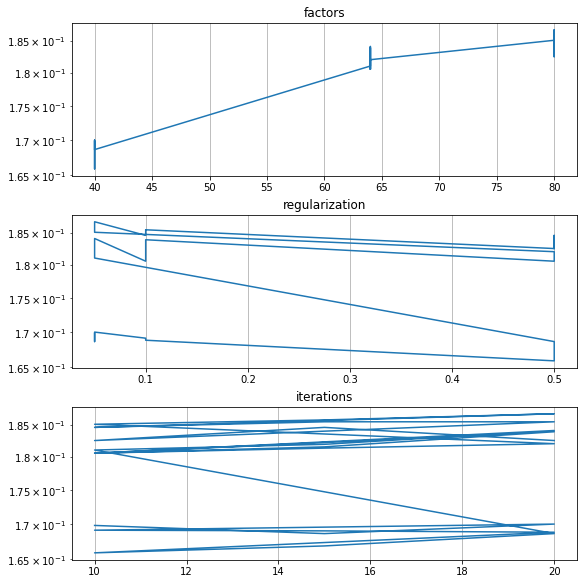

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x1 = [params[i][0] for i in range(len(params))]
x2 = [params[i][1] for i in range(len(params))]
x3 = [params[i][2] for i in range(len(params))]
y = [params[i][3] for i in range(len(params))]

# Create figure
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, constrained_layout=True, figsize=(8, 8))

ax0.semilogy(x1, y)
ax0.set(title='factors')
ax0.grid()

ax1.semilogy(x2, y)
ax1.set(title='regularization')
ax1.grid()

ax2.semilogy(x3, y)
ax2.set(title='iterations')
ax2.grid()

plt.show()

### **Выводы:**

- Количество вводимых факторов улучшает метрику.
- Изменение параметра количества итераций и коэффициента регуляризации не имеет оказывает прямого воздействия на метрику, только в сочетании с другими параметрами.
- Для сравнения результатов необходимо зафиксировать значение random_state.

In [ ]:
# Подставим лучшие параметры

model = AlternatingLeastSquares(factors=80, 
                                regularization=0.05,
                                iterations=20, 
                                calculate_training_loss=True, 
                                num_threads=5,
                                random_state=42)

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

result['als_gs'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
result.apply(lambda row: precision_at_k(row['als_gs'], row['actual']), axis=1).mean()

0.18677766895200784

In [ ]:
result.head()

,user_id,actual,als,als_tfidf,als_bm25,als_gs
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[1051211, 1033142, 1100972, 832678, 999999]","[999999, 1082185, 901062, 995242, 1024306]","[999999, 1082185, 1100972, 995242, 5569374]","[999999, 995242, 1082185, 1100972, 934369]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[5568378, 1106523, 951590, 910032, 1092026]","[951590, 999999, 1106523, 1133018, 1029743]","[999999, 951590, 1053690, 1133018, 883404]","[999999, 951590, 1133018, 1053690, 1092026]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[878996, 1007195, 1024306, 866227, 1051516]","[1024306, 1023720, 1051516, 1127831, 834484]","[1082185, 1024306, 999999, 930118, 878996]","[1024306, 1082185, 1007195, 1023720, 999999]"
3,7,"[840386, 889774, 898068, 909714, 929067, 95347...","[999999, 1082185, 1106523, 1058997, 6534178]","[999999, 1082185, 6534178, 826249, 1029743]","[999999, 849843, 1082185, 6944571, 1122358]","[999999, 1082185, 6944571, 849843, 1058997]"
4,8,"[835098, 872137, 910439, 924610, 992977, 10412...","[938700, 1068719, 883404, 1053690, 1004906]","[1053690, 965766, 938700, 833715, 1068719]","[999999, 883404, 995242, 840361, 965766]","[999999, 840361, 1004906, 1068719, 1082185]"


# Links

BM25

https://en.wikipedia.org/wiki/Okapi_BM25#:~:text=BM25%20is%20a%20bag%2Dof,slightly%20different%20components%20and%20parameters.


Matrix factorization (ALS, SVD)
https://datasciencemadesimpler.wordpress.com/tag/alternating-least-squares/